In [1]:
import os
import numpy as np
import json
from matplotlib import pyplot as plt
import torch
from utils.data import load_mat
# from models.DAS import DAS
# from kwave.utils import *
from kwave.ktransducer import *

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_path = './data'

In [2]:
sino = np.array([[1, 2],
                 [3, 4],
                 [5, 6]]) # [N L], intensity
id = np.array([[0, 1, 0, 1],
              [0, 1, 0, 2],
              [0, 1, 0, 1]]) # [N HW], L
id_val = id <= 1
print(id_val)
id_ravel= id[id_val].ravel() # N
print(id_ravel)
id_t = np.array([[0, 0, 0, 0],
                 [1, 1, 1, 1],
                 [2, 2, 2, 2]]) # N
# id_t = torch.arange(3).view(3,1).repeat(1, 4)
related = np.zeros((3, 4)) # [N HW]

[[ True  True  True  True]
 [ True  True  True False]
 [ True  True  True  True]]
[0 1 0 1 0 1 0 0 1 0 1]


In [3]:
related[id_val] = sino[id_t[id_val], id[id_val]]
related

array([[1., 2., 1., 2.],
       [3., 4., 3., 0.],
       [5., 6., 5., 6.]])

In [4]:
import torch
from torch import nn


class DAS(nn.Module):
    def __init__(self, R_ring, T_sample, v0, x_vec, y_vec, d_delay=0, ring_error=0):
        super(DAS, self).__init__()
        self.R_ring = torch.tensor(R_ring)
        self.T_sample = torch.tensor(T_sample)
        self.v0 = torch.tensor(v0)
        self.x_vec = torch.tensor(x_vec).view(1, -1, 1)
        self.y_vec = torch.tensor(y_vec).view(1, 1, -1)
        self.ring_error = torch.tensor(ring_error)

    def forward(self, sinogram, d_delay=0):
        N_transducer, H, W = sinogram.shape[0], self.x_vec.shape[1], self.y_vec.shape[2]
        
        angle_transducer = 2 * torch.pi / N_transducer * (torch.arange(N_transducer) + 1).view(-1, 1, 1)
        x_transducer = self.R_ring * torch.sin(angle_transducer - torch.pi)
        y_transducer = self.R_ring * torch.cos(angle_transducer - torch.pi)
        distance_to_transducer = torch.sqrt((x_transducer - self.x_vec)**2 + (y_transducer - self.y_vec)**2) #- d_delay #+ self.ring_error
        id = torch.round(distance_to_transducer / (self.v0 * self.T_sample)).int()
        id_val = (id >= 0) * (id <= sinogram.shape[1])
        
        related_data = torch.zeros((N_transducer, H, W), device=sinogram.device)
        id_t = torch.arange(N_transducer).view(N_transducer,1,1).repeat(1,H,W)
        related_data[id_val] = sinogram[[id_val], id[id_val]]
        
        return related_data.mean(0)

In [5]:
sinogram_uniform = load_mat(os.path.join(data_path, 'sinogram_simulation_uniform.mat'))
sinogram_uniform = torch.from_numpy(sinogram_uniform).float().to(device)

In [6]:
Nx, Ny = 560, 560
R_ring = 0.05   # Radius of the ring array [m].
dx, dy = 4e-5, 4e-5
kgrid = kWaveGrid([Nx, Ny], [dx, dy])

In [7]:
model = DAS(0.05, 1/(40e6), 1508, kgrid.x_vec[:], kgrid.y_vec[:])
model.to(device)
model.eval()

DAS()

In [8]:
img = model(sinogram_uniform)

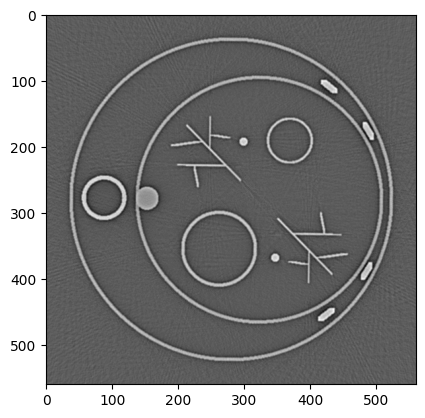

In [9]:
plt.imshow(img.cpu().detach().numpy(), cmap='gray')